In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
transform = transforms.ToTensor()

In [3]:
train_data = datasets.MNIST(root='../Data', train=True, download=True, transform=transform)


100%|██████████| 9.91M/9.91M [00:00<00:00, 18.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 489kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.56MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.0MB/s]


In [4]:
test_data = datasets.MNIST(root='../Data', train=False, download=True, transform=transform)

In [5]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../Data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [6]:
test_data


Dataset MNIST
    Number of datapoints: 10000
    Root location: ../Data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [7]:
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [8]:
class ConvolutionalNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,6,3,1)
        self.conv2 = nn.Conv2d(6,16,3,1)
        self.fc1 = nn.Linear(5*5*16,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 5*5*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)


In [9]:
criterion = nn.CrossEntropyLoss()
model = ConvolutionalNetwork()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [10]:
import time
start_time = time.time()

In [11]:
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

In [12]:
for i in range(epochs):

    trn_corr = 0
    tst_corr = 0


    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1

        # Apply the model
        y_pred = model(X_train)  # we not flatten X-train here
        loss = criterion(y_pred, y_train)


        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()  # Trure 1 / False 0 sum()
        trn_corr += batch_corr

        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%600 == 0:
            print(f'epoch: {i}  batch: {b} loss: {loss.item()}')

    train_losses.append(loss)
    train_correct.append(trn_corr)

    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

current_time = time.time()
total = current_time - start_time
print(f'Training took {total/60} minutes')

epoch: 0  batch: 600 loss: 0.1763140857219696
epoch: 0  batch: 1200 loss: 0.031977228820323944
epoch: 0  batch: 1800 loss: 0.1114189475774765
epoch: 0  batch: 2400 loss: 0.14287278056144714
epoch: 0  batch: 3000 loss: 0.028391968458890915
epoch: 0  batch: 3600 loss: 0.007227523718029261
epoch: 0  batch: 4200 loss: 0.05779891088604927
epoch: 0  batch: 4800 loss: 0.05178244784474373
epoch: 0  batch: 5400 loss: 0.0011467116419225931
epoch: 0  batch: 6000 loss: 0.0074218204244971275
epoch: 1  batch: 600 loss: 0.0001882580982055515
epoch: 1  batch: 1200 loss: 0.04644296318292618
epoch: 1  batch: 1800 loss: 0.06096656247973442
epoch: 1  batch: 2400 loss: 0.000984293525107205
epoch: 1  batch: 3000 loss: 0.0091342031955719
epoch: 1  batch: 3600 loss: 0.09886748343706131
epoch: 1  batch: 4200 loss: 0.1348010152578354
epoch: 1  batch: 4800 loss: 0.008983848616480827
epoch: 1  batch: 5400 loss: 0.019538812339305878
epoch: 1  batch: 6000 loss: 0.02810201421380043
epoch: 2  batch: 600 loss: 0.00410

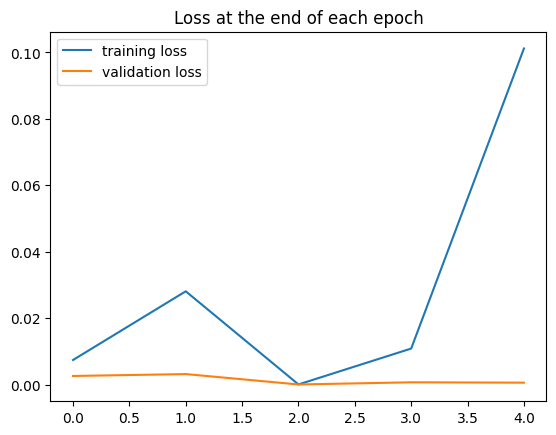

In [13]:
train_losses = [t.detach().numpy() for t in train_losses]
test_losses = [t.detach().numpy() for t in test_losses]

plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();
plt.show()

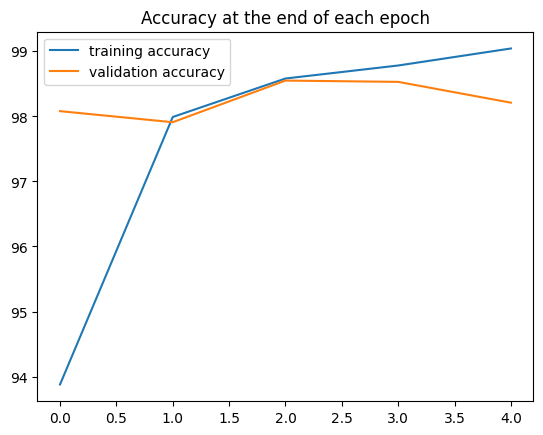

In [14]:
plt.plot([t/600 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();
plt.show()

In [15]:
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))
print(np.arange(10).reshape(1,10))
print()

print(confusion_matrix(predicted.view(-1), y_test.view(-1)))

[[   0    1    2    3    4    5    6    7    8    9]]

[[   1    0    0    0    0    0    0    0    0    0]
 [   0    1    0    0    0    0    0    0    0    0]
 [   0    0    1    0    0    0    0    0    0    0]
 [   0    0    0    1    0    0    0    0    0    0]
 [   0    0    0    0    1    0    0    0    0    0]
 [   0    0    0    0    0    1    0    0    0    0]
 [   0    0    0    0    0    0    1    0    0    0]
 [   0    0    0    0    0    0    0    1    0    0]
 [   0    0    0    0    0    0    0    0    1    0]
 [   0    0    0    0    0    0    0    0    0    1]]


In [ ]:
torch.save(model.state_dict(),'kabilan T.pt')